# Music Recommendation System using ALS Algorithm in PySpark

#### For Big Data Lab by Ronan Lobo(210962004) and Gautam Bhagat(210962040)

In this notebook, we will implement a music recommendation system using the Alternating Least Squares (ALS) algorithm in PySpark. ALS is a collaborative filtering algorithm that is commonly used for recommendation systems, particularly in scenarios where explicit feedback (ratings) is not available.

## Introduction

Music recommendation systems are essential for providing personalized recommendations to users based on their listening history and preferences. These systems analyze user interactions with music items such as listening history, likes, and dislikes to generate personalized recommendations.

## Dataset

For this project, we will use a dataset containing user interactions with music items. The dataset includes information such as user IDs, item IDs (music tracks), and any associated ratings or implicit feedback.

## Implementation

We will implement the recommendation system using PySpark, a powerful library for large-scale data processing. PySpark provides convenient APIs for distributed computing, making it suitable for handling large datasets efficiently.

### Steps:

1. **Data Preprocessing**: We will preprocess the dataset to handle missing values, clean the data, and prepare it for training.

2. **Model Training**: Using the ALS algorithm provided by PySpark's MLlib library, we will train a recommendation model on the preprocessed data.

3. **Model Evaluation**: We will evaluate the performance of the trained model using appropriate evaluation metrics to ensure its effectiveness.

4. **Recommendation Generation**: Finally, we will use the trained model to generate personalized music recommendations for users based on their preferences and listening history.

## Conclusion

Music recommendation systems play a crucial role in enhancing user experience by providing personalized recommendations. By implementing a recommendation system using the ALS algorithm in PySpark, we can effectively generate relevant music recommendations for users, thereby improving user engagement and satisfaction.


## Mounting Google Drive in Google Colab

To mount Google Drive in Google Colab, you can use the following code snippet. First, import the necessary module with `from google.colab import drive`. Then, execute `drive.mount('/content/drive')` to mount your Google Drive to the specified directory '/content/drive'.
This allows seamless access to files and folders stored in the user's Google Drive directly within the Colab environment, facilitating easy integration of external data sources into Colab notebooks.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installing PySpark

After executing this code cell, PySpark will be installed and ready to use in the notebook environment. PySpark enables efficient distributed data processing using the Apache Spark framework, making it suitable for working with large-scale datasets and performing complex analytics tasks.


In [ ]:
!pip install pyspark --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## PySpark Setup

It's time to set up the PySpark environment for data analysis and machine learning tasks. Here's a quick overview:

- **Importing Modules**: It imports necessary modules from PySpark, such as `SparkSession`, `functions`, `StringIndexer`, `ALS`, etc.
- **Setting Up SparkSession**: `SparkSession` is initialized to interact with Spark functionality.
- **Defining Functions**: Functions like `udf` are defined for custom operations.
- **Setting up ML Pipeline**: It sets up a pipeline for machine learning tasks.
- **ALS Recommendation Model**: `ALS` is imported for collaborative filtering based recommendation systems.
- **Model Tuning**: It imports modules for model tuning using techniques like Train-Validation Split and Parameter Grid Builder.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, desc, col, max, udf
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator

Matplotlib is a comprehensive plotting library in Python that enables users to create a wide range of high-quality static, interactive, and animated visualizations for data analysis and presentation. We will use it for the graphical presentations in this project.


In [ ]:
import matplotlib.pyplot as plt

## SparkSession Initialization

Initialize a SparkSession named "music_recommender" using PySpark.

- **SparkSession**: `SparkSession` is the entry point to Spark functionality in PySpark.
- **Builder Pattern**: `SparkSession.builder` is used to create a builder object to configure the session.
- **Setting Application Name**: `.appName("music_recommender")` sets the name of the Spark application to "music_recommender".
- **Creating Session**: `.getOrCreate()` method creates a new session or retrieves an existing one if available.

This line of code is typically the first step in any PySpark application, providing the necessary environment for Spark operations.



In [ ]:
spark = SparkSession.builder.appName("music_recommender").getOrCreate()

## Loading Data

Load a CSV file containing listening data into a PySpark DataFrame.

- **File Path**: `file_path` variable specifies the location of the CSV file.
- **Reading CSV**: `spark.read.format('csv').option('header', True).option('inferSchema', True).load(file_path)` reads the CSV file into a DataFrame.
  - `.format('csv')` specifies the format of the file.
  - `.option('header', True)` indicates that the first row of the CSV contains column names.
  - `.option('inferSchema', True)` automatically infers the data types of columns.
  - `.load(file_path)` loads the data from the specified file path.
- **Displaying Data**: `df_listenings.show()` displays the first few rows of the DataFrame.

This code is used to quickly load and inspect data from a CSV file for further analysis in the PySpark environment.


In [ ]:
file_path = '/content/drive/MyDrive/BDALabProject/dataset/listenings.csv'
df_listenings = spark.read.format('csv').option('header', True).option('inferSchema', True).load(file_path)

df_listenings.show()

+-----------+-------------+--------------------+---------------+--------------------+
|    user_id|         date|               track|         artist|               album|
+-----------+-------------+--------------------+---------------+--------------------+
|000Silenced|1299680100000|           Price Tag|       Jessie J|         Who You Are|
|000Silenced|1299679920000|Price Tag (Acoust...|       Jessie J|           Price Tag|
|000Silenced|1299679440000|Be Mine! (Ballad ...|          Robyn|            Be Mine!|
|000Silenced|1299679200000|            Acapella|          Kelis|            Acapella|
|000Silenced|1299675660000|   I'm Not Invisible|      The Tease|   I'm Not Invisible|
|000Silenced|1297511400000|Bounce (Feat NORE...|       MSTRKRFT|         Fist of God|
|000Silenced|1294498440000|Don't Stop The Mu...|        Rihanna|Addicted 2 Bassli...|
|000Silenced|1292438340000|               ObZen|      Meshuggah|               ObZen|
|000Silenced|1292437740000|   Yama's Messengers|      

The data information is not required for our project and can thus be dropped from the dataframe.

In [ ]:
df_listenings = df_listenings.drop('date')
df_listenings.show()

+-----------+--------------------+---------------+--------------------+
|    user_id|               track|         artist|               album|
+-----------+--------------------+---------------+--------------------+
|000Silenced|           Price Tag|       Jessie J|         Who You Are|
|000Silenced|Price Tag (Acoust...|       Jessie J|           Price Tag|
|000Silenced|Be Mine! (Ballad ...|          Robyn|            Be Mine!|
|000Silenced|            Acapella|          Kelis|            Acapella|
|000Silenced|   I'm Not Invisible|      The Tease|   I'm Not Invisible|
|000Silenced|Bounce (Feat NORE...|       MSTRKRFT|         Fist of God|
|000Silenced|Don't Stop The Mu...|        Rihanna|Addicted 2 Bassli...|
|000Silenced|               ObZen|      Meshuggah|               ObZen|
|000Silenced|   Yama's Messengers|         Gojira|The Way of All Flesh|
|000Silenced|On the Brink of E...|   Napalm Death|Time Waits For No...|
|000Silenced|On the Brink of E...|   Napalm Death|Time Waits For

## Handling Missing Values

Remove rows with any missing values (NaNs) from the DataFrame `df_listenings`.

- **Handling Missing Values**: `df_listenings.na.drop()` removes rows containing any missing values.

This operation helps in ensuring data quality by excluding incomplete or unreliable records from the analysis.


In [ ]:
df_listenings = df_listenings.na.drop()
df_listenings.show()

+-----------+--------------------+---------------+--------------------+
|    user_id|               track|         artist|               album|
+-----------+--------------------+---------------+--------------------+
|000Silenced|           Price Tag|       Jessie J|         Who You Are|
|000Silenced|Price Tag (Acoust...|       Jessie J|           Price Tag|
|000Silenced|Be Mine! (Ballad ...|          Robyn|            Be Mine!|
|000Silenced|            Acapella|          Kelis|            Acapella|
|000Silenced|   I'm Not Invisible|      The Tease|   I'm Not Invisible|
|000Silenced|Bounce (Feat NORE...|       MSTRKRFT|         Fist of God|
|000Silenced|Don't Stop The Mu...|        Rihanna|Addicted 2 Bassli...|
|000Silenced|               ObZen|      Meshuggah|               ObZen|
|000Silenced|   Yama's Messengers|         Gojira|The Way of All Flesh|
|000Silenced|On the Brink of E...|   Napalm Death|Time Waits For No...|
|000Silenced|On the Brink of E...|   Napalm Death|Time Waits For

## Data Summary

This code cell computes and displays summary statistics about the DataFrame `df_listenings`.

- **Counting Data Points**: `row_count = df_listenings.count()` calculates the number of data points (rows) in the DataFrame.
- **Counting Features**: `column_count = len(df_listenings.columns)` calculates the number of features (columns) in the DataFrame.
- **Displaying Summary**: The code then prints the number of data points and features to the output.

This summary provides a quick overview of the size and dimensions of the dataset, aiding in understanding its structure and scale.

In [ ]:
row_count = df_listenings.count()
column_count = len(df_listenings.columns)

print('Number of data points: ', row_count)
print('Number of features: ', column_count)

Number of data points:  13758905
Number of features:  4


## Caching DataFrame

This code cell caches the DataFrame `df_listenings`, storing it in memory for faster access.

- **Caching Data**: `df_listenings.cache()` caches the DataFrame in memory.
  
Caching is particularly useful for iterative algorithms or when you need to reuse the DataFrame multiple times within the same computation, as it avoids recomputation of the DataFrame each time it is accessed. However, it's essential to consider memory constraints when caching large datasets.


In [ ]:
df_listenings = df_listenings.cache()

## Data Exploration

The next few code cells extract the number of unique tracks, artists, and albums are present in the dataset.

These provides insight into the diversity present in the dataset, which can be crucial for understanding user preferences or content popularity.

- **Selecting Unique Tracks**: `tracks = df_listenings.select('track').distinct()` selects unique track names from the DataFrame.

In [ ]:
tracks = df_listenings.select('track').distinct()
tracks_count = tracks.count()

print('Number of unique tracks: ', tracks_count)

Number of unique tracks:  1455159


- **Selecting Unique Artists**: `artists = df_listenings.select('artist').distinct()` selects unique artist names from the DataFrame.

In [ ]:
artists = df_listenings.select('artist').distinct()
artists_count = artists.count()

print('Number of unique artists: ', artists_count)

Number of unique artists:  303661


- **Selecting Unique Albums**: `albums = df_listenings.select('album').distinct()` selects unique album names from the DataFrame.

In [ ]:
albums = df_listenings.select('album').distinct()
albums_count = albums.count()

print('Number of unique albums: ', albums_count)

Number of unique albums:  665441


## Counting Actual Unique Tracks

Extract unique combinations of track, artist, and album from the DataFrame `df_listenings`, considering all three attributes collectively, and count them.

- **Selecting Unique Tracks**: `unique_tracks = df_listenings.select('track', 'artist', 'album').distinct().cache()` selects unique combinations of track, artist, and album from the DataFrame.

This analysis provides a more comprehensive understanding of the diversity of tracks, considering not only the track name but also the associated artist and album since there could be multiple artists publishing tracks with the same names.

In [ ]:
unique_tracks = df_listenings.select('track', 'artist', 'album').distinct().cache()
unique_tracks_count = unique_tracks.count()

print('Number of actual unique tracks: ', unique_tracks_count)

Number of actual unique tracks:  2849915


In [ ]:
unique_tracks_save_path = '/content/drive/MyDrive/BDALabProject/Results/unique_tracks.csv'

unique_tracks.toPandas().to_csv(unique_tracks_save_path)

## Top Tracks Analysis

Compute the top tracks based on the number of times they appear in the dataset.

- **Selecting Relevant Columns**: The code selects the 'track', 'artist', and 'album' columns from the DataFrame.
- **Grouping and Aggregating**: It then groups the data by 'track', 'artist', and 'album', aggregating the counts of each combination.
- **Sorting**: The data is sorted in descending order based on the count of listens.
- **Displaying Top Tracks**: The code displays the top tracks, along with their respective artists and albums, showing the count of listens for each track.

This analysis provides insights into the most frequently listened to tracks, considering both individual tracks and their associated artists and albums.


In [ ]:
top_tracks = df_listenings.select('track', 'artist', 'album').groupby('track', 'artist', 'album').agg(count('*').alias('count')).orderBy('count', ascending=False).cache()
top_tracks.show()

+--------------------+-----------------+--------------------+-----+
|               track|           artist|               album|count|
+--------------------+-----------------+--------------------+-----+
|         Skinny Love|         Bon Iver|            For Emma| 2780|
|               Sorry|    Justin Bieber|    Purpose (Deluxe)| 2555|
|    Do I Wanna Know?|   Arctic Monkeys|                  AM| 2271|
|            The Cave|   Mumford & Sons|        Sigh No More| 2250|
|              A-Punk|  Vampire Weekend|     Vampire Weekend| 2047|
|           Lush Life|     Zara Larsson|           Lush Life| 1984|
|        Stressed Out|Twenty One Pilots|          Blurryface| 1939|
|         Crystalised|           The xx|                  xx| 1923|
|             Islands|           The xx|                  xx| 1923|
|               Intro|           The xx|                  xx| 1893|
|     Little Lion Man|   Mumford & Sons|        Sigh No More| 1892|
|I Bet You Look Go...|   Arctic Monkeys|Whatever

In [ ]:
top_tracks_save_path = '/content/drive/MyDrive/BDALabProject/Results/top_tracks.csv'

top_tracks.toPandas().to_csv(top_tracks_save_path)

Select the top 20 songs from the dataset.

In [ ]:
top_20_rows = top_tracks.limit(10)

top_20_rows.show()

+----------------+-----------------+----------------+-----+
|           track|           artist|           album|count|
+----------------+-----------------+----------------+-----+
|     Skinny Love|         Bon Iver|        For Emma| 2780|
|           Sorry|    Justin Bieber|Purpose (Deluxe)| 2555|
|Do I Wanna Know?|   Arctic Monkeys|              AM| 2271|
|        The Cave|   Mumford & Sons|    Sigh No More| 2250|
|          A-Punk|  Vampire Weekend| Vampire Weekend| 2047|
|       Lush Life|     Zara Larsson|       Lush Life| 1984|
|    Stressed Out|Twenty One Pilots|      Blurryface| 1939|
|     Crystalised|           The xx|              xx| 1923|
|         Islands|           The xx|              xx| 1923|
|           Intro|           The xx|              xx| 1893|
+----------------+-----------------+----------------+-----+



Plot the Top Songs against their Count

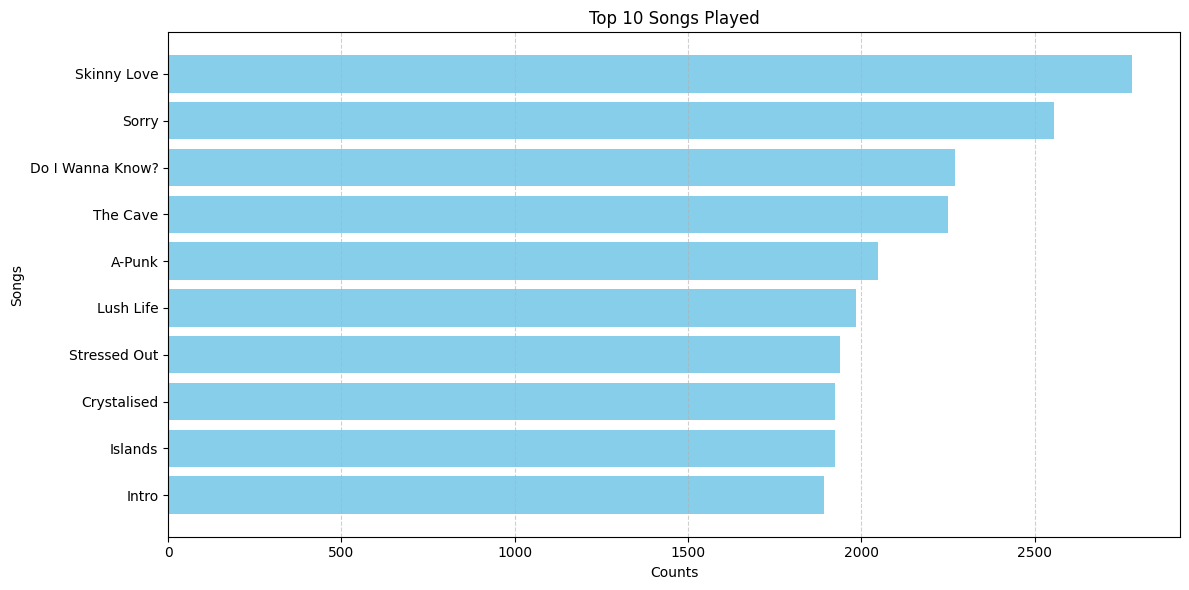

In [ ]:
top_20_pd = top_20_rows.toPandas()

plt.figure(figsize=(12, 6))
plt.barh(top_20_pd['track'], top_20_pd['count'], color='skyblue')
plt.xlabel("Counts")
plt.ylabel("Songs")
plt.title("Top 10 Songs Played")
plt.gca().invert_yaxis()

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

# Data Transformations

## User-defined Function (UDF) Creation

This code cell defines a user-defined function (UDF) named `combine_strings`.

- **Function Definition**: The `combine_strings` function takes three input arguments (`col1`, `col2`, `col3`) and concatenates them using underscores.

UDFs are useful for performing custom operations on DataFrame columns, extending the functionality of PySpark for specific use cases.


In [ ]:
def combine_strings(col1, col2, col3):
  return "_".join([col1, col2, col3])

combine_udf = udf(combine_strings, StringType())

## Combining Track Information

This code cell creates a new column named 'track_info' in the DataFrame `df_listenings`.

- **Using UDF**: The `combine_udf` function is applied to combine the 'track', 'artist', and 'album' columns into a single string separated by underscores.

This operation consolidates relevant information about each track into a single column, simplifying further analysis or processing.


In [ ]:
df_listenings = df_listenings.withColumn(
    'track_info',
    combine_udf(col('track'), col('artist'), col('album'))
)

df_listenings.show()

+-----------+--------------------+---------------+--------------------+--------------------+
|    user_id|               track|         artist|               album|          track_info|
+-----------+--------------------+---------------+--------------------+--------------------+
|000Silenced|           Price Tag|       Jessie J|         Who You Are|Price Tag_Jessie ...|
|000Silenced|Price Tag (Acoust...|       Jessie J|           Price Tag|Price Tag (Acoust...|
|000Silenced|Be Mine! (Ballad ...|          Robyn|            Be Mine!|Be Mine! (Ballad ...|
|000Silenced|            Acapella|          Kelis|            Acapella|Acapella_Kelis_Ac...|
|000Silenced|   I'm Not Invisible|      The Tease|   I'm Not Invisible|I'm Not Invisible...|
|000Silenced|Bounce (Feat NORE...|       MSTRKRFT|         Fist of God|Bounce (Feat NORE...|
|000Silenced|Don't Stop The Mu...|        Rihanna|Addicted 2 Bassli...|Don't Stop The Mu...|
|000Silenced|               ObZen|      Meshuggah|               ObZen

## Select User ID and Track Information

Selects the 'user_id' and 'track_info' columns from the DataFrame `df_listenings`.

- **Selecting Columns**: `df_listenings.select('user_id', 'track_info')` retains only the 'user_id' and 'track_info' columns.

This operation prepares the data for further analysis or modeling, focusing on user-track interactions.


In [ ]:
df_listenings = df_listenings.select('user_id', 'track_info').cache()
df_listenings.show()

+-----------+--------------------+
|    user_id|          track_info|
+-----------+--------------------+
|000Silenced|Price Tag_Jessie ...|
|000Silenced|Price Tag (Acoust...|
|000Silenced|Be Mine! (Ballad ...|
|000Silenced|Acapella_Kelis_Ac...|
|000Silenced|I'm Not Invisible...|
|000Silenced|Bounce (Feat NORE...|
|000Silenced|Don't Stop The Mu...|
|000Silenced|ObZen_Meshuggah_O...|
|000Silenced|Yama's Messengers...|
|000Silenced|On the Brink of E...|
|000Silenced|On the Brink of E...|
|000Silenced|In Deference_Napa...|
|000Silenced|Post(?)organic_De...|
|000Silenced|Mind Feeders_Dom ...|
|000Silenced|Necrosadistic War...|
|000Silenced|Dance All Night_D...|
|000Silenced|Late Night_Dom & ...|
|000Silenced|Freak Seen_Dom & ...|
|000Silenced|Paradrenasite (Hi...|
|000Silenced|Rhino_Dom & Rolan...|
+-----------+--------------------+
only showing top 20 rows



## Aggregating User-Track Interactions

Aggregate user-track interactions in the DataFrame `df_listenings`.

- **Grouping and Aggregating**: It groups the data by 'user_id' and 'track_info', aggregating the counts of each user-track combination.
- **Sorting**: The aggregated data is sorted by 'user_id'.

This aggregation provides insights into user preferences and engagement with specific tracks, facilitating personalized recommendations or targeted analysis. This will prepare the data in the required format for the ALS Algorithm to be applied later.



In [ ]:
df_listenings_agg = df_listenings.groupby('user_id', 'track_info').agg(count('*').alias('count')).orderBy('user_id').cache()
df_listenings_agg.show()

+-------+--------------------+-----+
|user_id|          track_info|count|
+-------+--------------------+-----+
| --Seph|0040_Ólafur Arnal...|    1|
| --Seph|Comment Te Dire A...|    1|
| --Seph|Flashback (Eric P...|    1|
| --Seph|Hey There Delilah...|    1|
| --Seph|I Miss You_Kimya ...|    1|
| --Seph|Julia_Ludovico Ei...|    1|
| --Seph|Jupiter_ the Brin...|    1|
| --Seph|La fille aux chev...|    1|
| --Seph|Monday_Ludovico E...|    1|
| --Seph|Phantom Pt II_Jus...|    1|
| --Seph|Reggae Merengue_T...|    1|
| --Seph|Sea Lawn_Caspian_...|    1|
| --Seph|Sunset Soon Forgo...|    1|
| --Seph|Talk to Me_ Dance...|    1|
| --Seph|The Nuclear Famil...|    2|
| --Seph|These Days_Nico_T...|    3|
| --Seph|Virus (Luke Fair ...|    1|
| --Seph|Water Music_Georg...|    1|
| --Seph|Winter '05_Ra Ra ...|    1|
| --Seph|Zeppelin_Michael ...|    1|
+-------+--------------------+-----+
only showing top 20 rows



In [ ]:
row_count = df_listenings_agg.count()

print('Number of unique data points: ', row_count)

Number of unique data points:  9978026


## Limiting Data Points for Analysis

This code cell limits the number of data points in the aggregated DataFrame `df_listenings_agg` to 100,000.

Limiting the number of data points is useful for managing computational resources and focusing analysis on a representative subset of the data.


In [ ]:
df_listenings_agg = df_listenings_agg.limit(100000)

df_listenings_agg = df_listenings_agg.cache()

## Indexing Categorical Columns with StringIndexer and Pipeline

Indexe categorical columns in the DataFrame `df_listenings_agg` using StringIndexer.

- **Columns Requiring Indexing**: `cols_requiring_indexing = ['user_id', 'track_info']` specifies the columns to be indexed.
- **Creating StringIndexer**: For each column, a StringIndexer is created with 'keep' strategy for handling invalid entries.
- **Pipeline Construction**: A pipeline is constructed with the created StringIndexers.
- **Fitting Pipeline**: `pipeline_model = pipeline.fit(df_listenings_agg)` fits the pipeline to the data.
- **Transforming Data**: `data = pipeline_model.transform(df_listenings_agg).cache()` transforms the data using the fitted pipeline.

Indexing categorical columns is essential for converting them into numerical representations, which is often required for machine learning algorithms.





In [ ]:
cols_requiring_indexing = ['user_id', 'track_info']

indexers = [StringIndexer(inputCol=col, outputCol=col+'_index').setHandleInvalid('keep') for col in cols_requiring_indexing]

pipeline = Pipeline(stages=indexers)

pipeline_model = pipeline.fit(df_listenings_agg)

data = pipeline_model.transform(df_listenings_agg).cache()
data.show()

+-------+--------------------+-----+-------------+----------------+
|user_id|          track_info|count|user_id_index|track_info_index|
+-------+--------------------+-----+-------------+----------------+
| --Seph|0040_Ólafur Arnal...|    1|        311.0|         10336.0|
| --Seph|Comment Te Dire A...|    1|        311.0|         22714.0|
| --Seph|Flashback (Eric P...|    1|        311.0|         30864.0|
| --Seph|Hey There Delilah...|    1|        311.0|          5726.0|
| --Seph|I Miss You_Kimya ...|    1|        311.0|         38783.0|
| --Seph|Julia_Ludovico Ei...|    1|        311.0|         42700.0|
| --Seph|Jupiter_ the Brin...|    1|        311.0|         42818.0|
| --Seph|La fille aux chev...|    1|        311.0|         44193.0|
| --Seph|Monday_Ludovico E...|    1|        311.0|         49928.0|
| --Seph|Phantom Pt II_Jus...|    1|        311.0|         56307.0|
| --Seph|Reggae Merengue_T...|    1|        311.0|         59124.0|
| --Seph|Sea Lawn_Caspian_...|    1|        311.

Save the models if you need to work with it later on.

In [ ]:
save_path_string_indexer = '/content/drive/MyDrive/BDALabProject/Models/'

for col, string_indexer in zip(cols_requiring_indexing, indexers):
  string_indexer.save(save_path_string_indexer + col + '_indexer.parquet')

## Selecting Indexed Columns

This code cell selects indexed columns 'user_id_index', 'track_info_index', and the 'count' column from the DataFrame `data`.

This operation prepares the data for further analysis or modeling, focusing on the indexed features and interaction counts.


In [ ]:
data = data.select('user_id_index', 'track_info_index', 'count').orderBy('user_id_index').cache()
data.show()

+-------------+----------------+-----+
|user_id_index|track_info_index|count|
+-------------+----------------+-----+
|          0.0|         10301.0|    1|
|          0.0|         12739.0|    1|
|          0.0|         16142.0|    1|
|          0.0|         17626.0|    1|
|          0.0|         18522.0|    1|
|          0.0|         18640.0|    1|
|          0.0|          4479.0|    1|
|          0.0|         23233.0|    1|
|          0.0|         25952.0|    1|
|          0.0|         26518.0|    1|
|          0.0|          5042.0|    1|
|          0.0|         31239.0|    1|
|          0.0|         31588.0|    1|
|          0.0|         31869.0|    1|
|          0.0|         32340.0|    1|
|          0.0|         34085.0|    1|
|          0.0|         35281.0|    1|
|          0.0|         36600.0|    1|
|          0.0|         39230.0|    1|
|          0.0|          6271.0|    1|
+-------------+----------------+-----+
only showing top 20 rows



## Splitting Data into Training and Testing Sets

Split the DataFrame `data` into training and testing sets.

- **Random Splitting**: `data.randomSplit([0.9, 0.1])` randomly splits the data into two sets with a 90:10 ratio for training and testing, respectively.
- **Caching**: Both the training and testing sets are cached for faster access.

- **Training Set**: `training` contains 90% of the data.
- **Testing Set**: `testing` contains 10% of the data.

Splitting the data into training and testing sets is essential for evaluating the performance of machine learning models and preventing overfitting.


In [ ]:
(training, testing) = data.randomSplit([0.9, 0.1])

training = training.cache()
testing = testing.cache()

## Training ALS Model

This code cell trains an ALS (Alternating Least Squares) model using the training data.

- **Model Configuration**: `ALS(maxIter=5, regParam=0.01, userCol=USERID, itemCol=TRACK, ratingCol=COUNT)` configures the ALS model with parameters such as maximum number of iterations (`maxIter`), regularization parameter (`regParam`), and columns for user, item, and ratings.
- **Fitting Model**: `model = als.fit(training)` fits the ALS model to the training data.

Training an ALS model involves learning latent factors for users and items from the interaction data, which can then be used to make personalized recommendations.


In [ ]:
USERID = 'user_id_index'
TRACK = 'track_info_index'
COUNT = 'count'

als = ALS(maxIter=5, regParam=0.01, userCol=USERID, itemCol=TRACK, ratingCol=COUNT)
model = als.fit(training)

Save Model to File

In [ ]:
model_save_path = '/content/drive/MyDrive/BDALabProject/Models/als_model.parquet'

model.save(model_save_path)

## Hyper Parameter Tuning to Find the Best Fit Model to Training Data

In [ ]:
estimator = ALS(userCol=USERID, itemCol=TRACK, ratingCol=COUNT)

In [ ]:
param_grid = ParamGridBuilder() \
    .addGrid(ALS.rank, [10, 20, 50, 100]) \
    .addGrid(ALS.maxIter, [5, 10, 20, 50]) \
    .addGrid(ALS.regParam, [0.01, 0.1, 1.0]) \
    .build()

In [ ]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol=COUNT, predictionCol="prediction")

In [ ]:
cv = CrossValidator(
    estimator=estimator,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3
)

model = cv.fit(training)

In [ ]:
best_model = model.bestModel

In [ ]:
best_rank = best_model.getParam("rank").value
best_maxIter = best_model.getParam("maxIter").value
best_regParam = best_model.getParam("regParam").value

print("Best hyperparameters: Rank = {}, MaxIter = {}, RegParam = {}".format(
    best_rank, best_maxIter, best_regParam))

In [ ]:
best_model_save_path = '/content/drive/MyDrive/BDALabProject/Models/als_best_model.parquet'

best_model.save(best_model_save_path)

## Making Predictions

This code cell generates predictions using the trained ALS model on the testing data.

- **Model Transformation**: `model.transform(testing)` applies the trained ALS model to the testing data, generating predictions.

These predictions represent the estimated ratings that users would give to items (tracks) based on their historical interactions, facilitating the evaluation of the model's performance.


In [ ]:
predictions = model.transform(testing)

rmse = evaluator.evaluate(predictions)

print("RMSE on testing set:", rmse)

In [ ]:
predictions.na.drop().orderBy('prediction', ascending=False).show()

+-------------+----------------+-----+----------+
|user_id_index|track_info_index|count|prediction|
+-------------+----------------+-----+----------+
|        396.0|          8774.0|    1| 24.804897|
|         17.0|            21.0|    2| 7.5002065|
|        481.0|          2682.0|    2|  5.154854|
|        351.0|           122.0|    5| 5.0818167|
|        505.0|           321.0|    1|  4.914898|
|        143.0|           293.0|    1| 4.7177505|
|        391.0|          1082.0|    1| 4.3436294|
|        221.0|           142.0|    1|  3.921738|
|        469.0|           589.0|    1| 3.8644288|
|         31.0|            51.0|    1| 3.5142295|
|        553.0|           639.0|    1| 3.4262812|
|        494.0|          1088.0|    1| 3.4215662|
|        723.0|           149.0|    5| 3.3853433|
|        220.0|           702.0|    1|  3.346715|
|        462.0|             3.0|    1| 3.2906518|
|        357.0|           674.0|    3| 3.2850478|
|        635.0|          8522.0|    3| 3.2459934|


## Generating Recommendations

Generate recommendations for all users using the trained ALS model.

- **Recommendation Generation**: `model.recommendForAllUsers(10)` generates recommendations for each user, recommending 10 items (tracks) per user.

These recommendations are based on the learned user and item factors from the ALS model and can be used to provide personalized recommendations to users.


In [ ]:
recs = model.recommendForAllUsers(10).cache()

recs.show()

+-------------+--------------------+
|user_id_index|     recommendations|
+-------------+--------------------+
|          471|[{26772, 15.80940...|
|          463|[{10100, 69.39462...|
|          496|[{18288, 26.28860...|
|          148|[{10100, 85.98897...|
|          540|[{10100, 43.06785...|
|          392|[{15320, 40.32162...|
|          243|[{18288, 27.05423...|
|          623|[{73763, 15.70791...|
|          737|[{47877, 17.80417...|
|           31|[{39179, 20.51527...|
|          516|[{74205, 35.60665...|
|          580|[{18288, 14.32968...|
|          251|[{15320, 19.69755...|
|          451|[{10100, 59.04345...|
|           85|[{43704, 27.92037...|
|          137|[{43704, 33.02311...|
|           65|[{47483, 25.16848...|
|          458|[{15320, 30.56639...|
|          481|[{47877, 24.00361...|
|           53|[{74205, 44.22038...|
+-------------+--------------------+
only showing top 20 rows



## Viewing User Recommendations

Retrieve recommendations for a random single user from the generated recommendations DataFrame.

- **Retrieving User Recommendations**: `recs.take(1)` retrieves recommendations for the first user in the DataFrame.

The recommendations for this user provide insights into the items (tracks) that the ALS model suggests they might be interested in based on their historical interactions and the learned user-item preferences.


In [ ]:
user_recs = recs.take(1)

user_recs

[Row(user_id_index=471, recommendations=[Row(track_info_index=26772, rating=15.80940055847168), Row(track_info_index=15320, rating=15.258801460266113), Row(track_info_index=18, rating=14.247913360595703), Row(track_info_index=73533, rating=10.86312484741211), Row(track_info_index=72335, rating=10.771251678466797), Row(track_info_index=8768, rating=10.74797534942627), Row(track_info_index=43897, rating=10.23143482208252), Row(track_info_index=76565, rating=9.28421688079834), Row(track_info_index=82072, rating=9.04973316192627), Row(track_info_index=9049, rating=8.283903121948242)])]

Retrive the user id of the user for whom we randomly generated recommendations

In [ ]:
user_id = user_recs[0].user_id_index

## Converting Recommendations to DataFrame

Converts the recommendations for a single user into a DataFrame.

- **Extracting Recommendations**: The code retrieves recommendations for the user from the recommendations DataFrame.
- **Creating Records**: It creates records containing track indices and corresponding ratings for the recommendations.
- **Creating DataFrame**: `spark.createDataFrame(records, ['track_info_index', 'rating'])` creates a DataFrame from the records with columns 'track_info_index' and 'rating'.

This DataFrame presents the recommended tracks for the user along with their associated ratings, aiding in understanding the relevance and potential interest of each recommended track.


In [ ]:
records = [(row.track_info_index, row.rating) for row in user_recs[0].recommendations]

user_recs_df = spark.createDataFrame(records, ['track_info_index', 'rating'])

user_recs_df.show()

+----------------+------------------+
|track_info_index|            rating|
+----------------+------------------+
|           26772| 15.80940055847168|
|           15320|15.258801460266113|
|              18|14.247913360595703|
|           73533| 10.86312484741211|
|           72335|10.771251678466797|
|            8768| 10.74797534942627|
|           43897| 10.23143482208252|
|           76565|  9.28421688079834|
|           82072|  9.04973316192627|
|            9049| 8.283903121948242|
+----------------+------------------+



## Index to String Conversion

Create an IndexToString transformer to convert indexed track information back to its original string representation.

- **Creating IndexToString Transformer**: `IndexToString(inputCol="track_info_index", outputCol="track_info", labels=pipeline_model.stages[1].labels)` creates an IndexToString transformer.
  - `inputCol="track_info_index"` specifies the input column containing the indexed track information.
  - `outputCol="track_info"` specifies the output column where the converted track information will be stored.
  - `labels=pipeline_model.stages[1].labels` provides the original labels (track names) to map the indexed values back to their original string representations.

This transformer is useful for converting the indexed track information back to its original string form, making the recommendations more interpretable and user-friendly.


In [ ]:
indexer_inv = IndexToString(inputCol="track_info_index", outputCol="track_info", labels=pipeline_model.stages[1].labels)

## Filtering and Sorting User History Data

We filter the training dataset (`training`) to extract user history data for a specific user, identified by their user ID index (`user_id`). We then sort this data by the count of interactions in descending order.


In [ ]:
user_hist = training.filter(training.user_id_index == user_id).orderBy('count', ascending=False).cache()

user_hist.show()

+-------------+----------------+-----+
|user_id_index|track_info_index|count|
+-------------+----------------+-----+
|        471.0|         78727.0|    6|
|        471.0|          3803.0|    4|
|        471.0|            21.0|    3|
|        471.0|           107.0|    3|
|        471.0|           207.0|    3|
|        471.0|           450.0|    3|
|        471.0|          1262.0|    3|
|        471.0|          5024.0|    3|
|        471.0|          6330.0|    3|
|        471.0|         21439.0|    3|
|        471.0|         21963.0|    3|
|        471.0|         34689.0|    3|
|        471.0|         37288.0|    3|
|        471.0|         42783.0|    3|
|        471.0|         52113.0|    3|
|        471.0|         67831.0|    3|
|        471.0|         73819.0|    3|
|        471.0|         78647.0|    3|
|        471.0|         80131.0|    3|
|        471.0|             5.0|    2|
+-------------+----------------+-----+
only showing top 20 rows



## Converting Indexed Tracks to Original Names

Use the `IndexToString` transformer to convert indexed track information back to its original string representation.

- **Applying IndexToString**: `indexer_inv.transform(name_of_df)` applies the `IndexToString` transformer to the DataFrame `name_of_df`, converting the indexed track information in the 'track_info_index' column to its original string representation in the 'track_info' column.

This transformation ensures that the recommended tracks are presented in their original names, making them more understandable and user-friendly.


In [ ]:
user_recs_df = indexer_inv.transform(user_recs_df)

user_recs_df.show()

+----------------+------------------+--------------------+
|track_info_index|            rating|          track_info|
+----------------+------------------+--------------------+
|           26772| 15.80940055847168|Dooo It!_Miley Cy...|
|           15320|15.258801460266113|Ave Maria_Beyoncé...|
|              18|14.247913360595703|The Cave_Mumford ...|
|           73533| 10.86312484741211|Thirsty Boots (Un...|
|           72335|10.771251678466797|The Second Stone_...|
|            8768| 10.74797534942627|The Boy Who Murde...|
|           43897| 10.23143482208252|Kohala - Gurgling...|
|           76565|  9.28421688079834|Unusual You_Britn...|
|           82072|  9.04973316192627|Young Blood_Sophi...|
|            9049| 8.283903121948242|The Waiting Room_...|
+----------------+------------------+--------------------+



In [ ]:
user_hist = indexer_inv.transform(user_hist)

user_hist.show()

+-------------+----------------+-----+--------------------+
|user_id_index|track_info_index|count|          track_info|
+-------------+----------------+-----+--------------------+
|        471.0|         78727.0|    6|Werkin' Girls_Ang...|
|        471.0|          3803.0|    4|Arrow_Tegan and S...|
|        471.0|            21.0|    3|Breezeblocks_alt-...|
|        471.0|           107.0|    3|Roll Away Your St...|
|        471.0|           207.0|    3|Tessellate_alt-J_...|
|        471.0|           450.0|    3|Do You Want It Al...|
|        471.0|          1262.0|    3|Small Bump_Ed She...|
|        471.0|          5024.0|    3|Everything Is Alr...|
|        471.0|          6330.0|    3|Keep Your Head Up...|
|        471.0|         21439.0|    3|Chi (Need To Know...|
|        471.0|         21963.0|    3|Cleaning Out My C...|
|        471.0|         34689.0|    3|Gypsy Letters_Ang...|
|        471.0|         37288.0|    3|Hot Like Fire_Ang...|
|        471.0|         42783.0|    3|Ju

## Converting PySpark DataFrame to Pandas DataFrame

Convert the PySpark DataFrames `user_hist_df` and `user_recs_df` containing to a Pandas DataFrame.

- **Converting to Pandas**: `name_of_df.toPandas()` converts the PySpark DataFrame to a Pandas DataFrame.

This conversion allows for easier manipulation, visualization, and further analysis using the rich functionality provided by Pandas.


In [ ]:
user_hist_pd = user_hist.toPandas()

user_recs_pd = user_recs_df.toPandas()

## Displaying Previous Previous History of User

Prints the history for a specific user.

This output displays the kind of songs that this user likes and loves listening to. Using this knowledge, we can match whether the recommendations from the ALS algorithm are similar to the user's history.


In [ ]:
print(f'User {user_id}\'s History of Songs:')

for i, row in user_hist_pd[:10].iterrows():
  split_info = row['track_info'].split('_')
  print(f'>>>"{split_info[0]}" by "{split_info[1]}" in "{split_info[2]}"')

User 471's History of Songs:
>>>"Werkin' Girls" by "Angel Haze" in "Reservation"
>>>"Arrow" by "Tegan and Sara" in "Sainthood"
>>>"Breezeblocks" by "alt-J" in "An Awesome Wave"
>>>"Roll Away Your Stone" by "Mumford & Sons" in "Sigh No More"
>>>"Tessellate" by "alt-J" in "An Awesome Wave"
>>>"Do You Want It All?" by "Two Door Cinema Club" in "Tourist History"
>>>"Small Bump" by "Ed Sheeran" in "+"
>>>"Everything Is Alright" by "Motion City Soundtrack" in "Commit This to Memory"
>>>"Keep Your Head Up" by "Ben Howard" in "Every Kingdom"
>>>"Chi (Need To Know)" by "Angel Haze" in "Reservation"


## Displaying User Recommendations

Print the recommendations for a specific user.

This output provides a user-friendly presentation of the recommended tracks for the specified user, including track name, artist, and album details.

In [ ]:
print('Recommendations for user', user_recs[0].user_id_index)

for i, row in user_recs_pd.iterrows():
  split_info = row['track_info'].split('_')
  print(f'>>>"{split_info[0]}" by "{split_info[1]}" in "{split_info[2]}"')

Recommendations for user 471
>>>"Dooo It!" by "Miley Cyrus" in "Мiley Cyrus And Her Dead Petz"
>>>"Ave Maria" by "Beyoncé" in "I Am Sasha Fierce"
>>>"The Cave" by "Mumford & Sons" in "Sigh No More"
>>>"Thirsty Boots (Unreleased" by " Self Portrait)" in "Bob Dylan"
>>>"The Second Stone" by "Epica" in "The Quantum Enigma"
>>>"The Boy Who Murdered Love" by "Diana Vickers" in "Songs From the Tainted Cherry Tree"
>>>"Kohala - Gurgling Stream for Sleep and Realax (White Noise Sounds for Baby Relaxation and Sleeping)" by "Baby Sleep Through the Night" in "Hawaiian Natural White Noise for Babies - Baby Sleep Aid with Relaxing Nature Sounds and Heart Beat Sound to Calm and Relax Your Baby"
>>>"Unusual You" by "Britney Spears" in "Circus (Deluxe Version)"
>>>"Young Blood" by "Sophie Ellis-Bextor" in "Wanderlust (Deluxe Wandermix Version)"
>>>"The Waiting Room" by "We Are the Ocean" in "Go Now And Live"


Display the same recommendations using a bar plot with the names of recommended tracks mapped against the rating with which the algorithm believes the user would like.

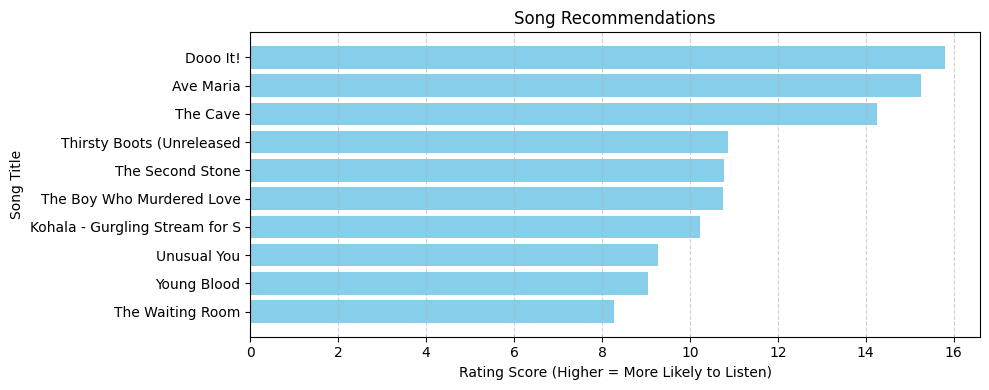

In [ ]:
track_names = [row['track_info'].split('_')[0][:30] for i, row in user_recs_pd.iterrows()]
ratings = [row['rating'] for i, row in user_recs_pd.iterrows()]

plt.figure(figsize=(10, 4))
plt.barh(track_names, ratings, color='skyblue')
plt.xlabel('Rating Score (Higher = More Likely to Listen)')
plt.ylabel('Song Title')
plt.title('Song Recommendations')
plt.gca().invert_yaxis()

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

## Thank You